## First of all I loaded all the data into Snowflake database for easier manipulation
I made a simple datamart with snap dates '2020-09-01', '2020-09-08' for training
and '2020-09-15' for testing, datamart was exported in one csv file named
model_build_base.csv

#### The train set contains following data:
* 495,774 rows of SOLD=1 -> All transactions that were sold in week '2020-09-01' to '2020-09-07' and week '2020-09-08' to '2020-09-15'
* 4,000,000 randomly chosen combinations of customer_id and article_id that were not sold with SOLD=0
* All article information, customer information and customer transaction history info is also joined

#### The test set contains following data:
* Similar to train set just shifted forward for week between '2020-09-15' and '2020-09-22'



#### Fitting
A simple XGBoost model was fitted


In [78]:
import warnings
warnings.filterwarnings('ignore')

In [52]:
#importing custom library
!pip install git+https://github.com/Vrboska/mofr@master

  Cloning https://github.com/Vrboska/mofr (to revision master) to /tmp/pip-req-build-ahmmiane
  Running command git clone --filter=blob:none --quiet https://github.com/Vrboska/mofr /tmp/pip-req-build-ahmmiane
  Running command git checkout -b master --track origin/master
  Switched to a new branch 'master'
  Branch 'master' set up to track remote branch 'master' from 'origin'.
  Resolved https://github.com/Vrboska/mofr to commit 9e35370debae10d418189ddd58b213a64b210895
  Preparing metadata (setup.py) ... done


In [53]:
import pandas as pd
import numpy as np
import random
import mofr
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier, plot_tree
import math

import xgboost as xgb

In [54]:
seed=1234

In [55]:
df=pd.read_csv('/kaggle/input/hm-model-build-base/model_build_base.csv').sample(100000)

In [56]:
len(df)

100000

In [57]:
df.head()

,SOLD,SNAP_DATE,CUSTOMER_ID,ARTICLE_ID,ACTIVE,CLUB_MEMBER_STATUS,FASHION_NEWS_FREQUENCY,AGE,QUANT_PG_ACCESSORIES_1M,QUANT_PG_BAGS_1M,...,ART_DAYS_SINCE_LAST_PURCHASE,ART_AVERAGE_PRICE,ART_NUM_CHANNEL_2,CUSTART_QUANTITY_SOLD_1M,CUSTART_QUANTITY_SOLD_3M,CUSTART_QUANTITY_SOLD_12M,CUSTART_QUANTITY_SOLD_OVERALL,CUSTART_DAYS_SINCE_FIRST_PURCHASE,CUSTART_DAYS_SINCE_LAST_PURCHASE,CUSTART_NUM_CHANNEL_2
4300411,0,2020-09-01,ba0d65520a2a7a6036f2a492dadf8d2b432bde29feb3c8...,772946002,0.0,ACTIVE,NONE,27.0,0.0,0.0,...,88,0.048959,1226.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5074789,1,2020-09-01,e90f4121a9efb36aa10f5607245ea4074cb0adac24da05...,852584006,0.0,ACTIVE,NONE,55.0,0.0,0.0,...,0,0.032997,276.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6125080,0,2020-09-15,4fe3a44974dda837a3a338f9cf461172c8d2b6ac39d741...,775345001,0.0,ACTIVE,NONE,21.0,0.0,0.0,...,55,0.019708,140.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5348374,0,2020-09-01,61d183dcae6e34fe8f5c2ccebd6b5b7f8b28ae48521c56...,620973001,0.0,ACTIVE,NONE,18.0,1.0,0.0,...,193,0.012081,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
154591,0,2020-09-15,2dbdc6efde46ff345bed0a27be932f03c65eced9040128...,734916001,0.0,ACTIVE,NONE,30.0,0.0,0.0,...,1,0.042062,40.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [58]:
train_mask=(df['SNAP_DATE']=='2020-09-08')|(df['SNAP_DATE']=='2020-09-01')
valid_mask=df['SNAP_DATE']=='2020-09-15'

In [59]:
df[train_mask]['SOLD'].value_counts()

0    59531
1     7074
Name: SOLD, dtype: int64

In [60]:
df[valid_mask]['SOLD'].value_counts()

0    29916
1     3479
Name: SOLD, dtype: int64

# Data Exploration

In [61]:
df[train_mask].describe()

,SOLD,ARTICLE_ID,ACTIVE,AGE,QUANT_PG_ACCESSORIES_1M,QUANT_PG_BAGS_1M,QUANT_PG_COSMETIC_1M,QUANT_PG_FUN_1M,QUANT_PG_FURNITURE_1M,QUANT_PG_GFB_1M,...,ART_DAYS_SINCE_LAST_PURCHASE,ART_AVERAGE_PRICE,ART_NUM_CHANNEL_2,CUSTART_QUANTITY_SOLD_1M,CUSTART_QUANTITY_SOLD_3M,CUSTART_QUANTITY_SOLD_12M,CUSTART_QUANTITY_SOLD_OVERALL,CUSTART_DAYS_SINCE_FIRST_PURCHASE,CUSTART_DAYS_SINCE_LAST_PURCHASE,CUSTART_NUM_CHANNEL_2
count,66605.000000,6.660500e+04,66605.000000,66306.000000,66605.000000,66605.000000,66605.000000,66605.0,66605.0,66605.000000,...,66605.000000,66605.000000,66605.000000,1227.000000,1227.000000,1227.000000,1227.000000,1227.000000,1227.000000,1227.000000
mean,0.106208,7.384957e+08,0.449110,35.641933,0.172975,0.002522,0.000060,0.0,0.0,0.478733,...,91.594250,0.030552,388.419893,1.037490,1.084760,1.176854,1.226569,32.317033,24.145884,0.916870
std,0.308106,1.258772e+08,0.497407,13.974203,0.667818,0.053351,0.007749,0.0,0.0,1.840941,...,110.658742,0.025346,1255.315612,1.162308,1.166828,1.179841,1.226081,104.629018,88.151115,1.312358
min,0.000000,1.087750e+08,0.000000,16.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.000788,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,0.000000,6.739400e+08,0.000000,24.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,2.000000,0.015979,15.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
50%,0.000000,7.564000e+08,0.000000,30.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,34.000000,0.024506,92.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000
75%,0.000000,8.314300e+08,1.000000,48.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,181.000000,0.037567,352.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000
max,1.000000,9.534500e+08,1.000000,95.000000,18.000000,3.000000,1.000000,0.0,0.0,89.000000,...,366.000000,0.506780,41863.000000,38.000000,38.000000,38.000000,38.000000,654.000000,654.000000,38.000000


In [62]:
df[train_mask].describe(include=['O'])

,SNAP_DATE,CUSTOMER_ID,CLUB_MEMBER_STATUS,FASHION_NEWS_FREQUENCY,ART_PRODUCT_GROUP_NAME,COLOUR,ART_PERCEIVED_COLOUR,ART_INDEX_CODE
count,66605,66605,66605,66605,66605,66605,66605,66605
unique,2,52534,4,4,18,12,8,10
top,2020-09-08,e3bb7cf1f1ee2120aafa2ea21c6f49092cdbfd8e570218...,ACTIVE,NONE,Garment Upper body,BLACK,Dark,A
freq,33553,7,65734,35951,27058,15878,27416,19121


# Data transformations

In [63]:
col_target='SOLD'
col_exclude=[
'SNAP_DATE',
'CUSTOMER_ID',
'ARTICLE_ID',
'ART_DAYS_SINCE_FIRST_PURCHASE',
'ART_DAYS_SINCE_LAST_PURCHASE',

col_target,
    

]+[col for col in df.columns if 'CUSTART' in col]

In [64]:
col_exclude

['SNAP_DATE',
 'CUSTOMER_ID',
 'ARTICLE_ID',
 'ART_DAYS_SINCE_FIRST_PURCHASE',
 'ART_DAYS_SINCE_LAST_PURCHASE',
 'SOLD',
 'CUSTART_QUANTITY_SOLD_1M',
 'CUSTART_QUANTITY_SOLD_3M',
 'CUSTART_QUANTITY_SOLD_12M',
 'CUSTART_QUANTITY_SOLD_OVERALL',
 'CUSTART_DAYS_SINCE_FIRST_PURCHASE',
 'CUSTART_DAYS_SINCE_LAST_PURCHASE',
 'CUSTART_NUM_CHANNEL_2']

## Categorical transformations

In [65]:
import category_encoders as ce

In [66]:
# potential predictors without encoding
cat_preds = [col for col in df.select_dtypes(include="object") if col not in col_exclude]
bool_preds = [col for col in df.select_dtypes(include="bool") if col not in col_exclude]
datetime_preds = [col for col in df.select_dtypes(include="datetime") if col not in col_exclude]

In [67]:
cat_preds

['CLUB_MEMBER_STATUS',
 'FASHION_NEWS_FREQUENCY',
 'ART_PRODUCT_GROUP_NAME',
 'COLOUR',
 'ART_PERCEIVED_COLOUR',
 'ART_INDEX_CODE']

### Target Encoding

In [68]:
# # bayesian target encoding
encoder = ce.TargetEncoder(min_samples_leaf=1, smoothing=1.0)
encoder.fit_transform(df[train_mask][cat_preds], df[train_mask][col_target])

df = pd.concat([df, encoder.transform(df[cat_preds]).add_prefix("BAYES_")], axis=1)

Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327


In [69]:
col_preds=[col for col in df.select_dtypes(include=["int","float"]) if col not in col_exclude]

In [70]:
len(col_preds)

86

# Fitting models

In [71]:
(df[train_mask][col_target]>0).value_counts(normalize=True)

False    0.893792
True     0.106208
Name: SOLD, dtype: float64

## XGBoost model

## Finding parameters with Hyperopt

In [72]:
from hyperopt import fmin, tpe, hp, anneal, Trials, STATUS_OK

In [73]:
space={'max_depth': hp.quniform("max_depth", 3, 6, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 100,
        'seed': 0
    }

In [76]:
def objective(space):
    sample_train=df[train_mask].sample(10000)
    sample_valid=df[valid_mask].sample(10000)

    clf=xgb.XGBRegressor(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))
    
    evaluation = [( sample_train[col_preds], sample_train[col_target]), ( sample_train[col_preds], sample_train[col_target])]
    
    clf.fit(sample_train[col_preds], sample_train[col_target],
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=10,verbose=False)
    

    pred = clf.predict(sample_valid[col_preds])
    gini = mofr.metrics.gini(sample_valid[col_target], pred)
    print ("SCORE:", gini)
    return {'loss': -gini, 'status': STATUS_OK }

In [77]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                 
0.44645543820074196                                    
  1%|          | 1/100 [00:00<00:41,  2.37trial/s, best loss: -0.44645543820074196]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.2943250266382569                                                                 
  2%|▏         | 2/100 [00:00<00:38,  2.52trial/s, best loss: -0.44645543820074196]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.3105555555555557                                                                 
  3%|▎         | 3/100 [00:01<00:37,  2.56trial/s, best loss: -0.44645543820074196]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.29572145606682754                                                                
  4%|▍         | 4/100 [00:01<00:37,  2.58trial/s, best loss: -0.44645543820074196]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.5125619315585257                                                                 
  5%|▌         | 5/100 [00:01<00:37,  2.51trial/s, best loss: -0.5125619315585257] 

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                            
0.3111674547172263                                                                
  6%|▌         | 6/100 [00:02<00:37,  2.53trial/s, best loss: -0.5125619315585257]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                            
0.42079263591056915                                                               
  7%|▋         | 7/100 [00:02<00:38,  2.39trial/s, best loss: -0.5125619315585257]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                            
0.42157601603654804                                                               
  8%|▊         | 8/100 [00:03<00:38,  2.38trial/s, best loss: -0.5125619315585257]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                            
0.2906675218015291                                                                
  9%|▉         | 9/100 [00:03<00:36,  2.47trial/s, best loss: -0.5125619315585257]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                            
0.4316124947235118                                                                
 10%|█         | 10/100 [00:04<00:36,  2.48trial/s, best loss: -0.5125619315585257]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.4312657111224052                                                                 
 11%|█         | 11/100 [00:04<00:35,  2.50trial/s, best loss: -0.5125619315585257]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.4797960729067263                                                                 
 12%|█▏        | 12/100 [00:04<00:34,  2.54trial/s, best loss: -0.5125619315585257]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.3084616465461243                                                                 
 13%|█▎        | 13/100 [00:05<00:33,  2.60trial/s, best loss: -0.5125619315585257]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.3228528752800597                                                                 
 14%|█▍        | 14/100 [00:05<00:32,  2.64trial/s, best loss: -0.5125619315585257]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.4688883595223525                                                                 
 15%|█▌        | 15/100 [00:05<00:32,  2.60trial/s, best loss: -0.5125619315585257]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.3084333110703623                                                                 
 16%|█▌        | 16/100 [00:06<00:32,  2.61trial/s, best loss: -0.5125619315585257]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.29801848293985667                                                                
 17%|█▋        | 17/100 [00:06<00:31,  2.67trial/s, best loss: -0.5125619315585257]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.40566102815842653                                                                
 18%|█▊        | 18/100 [00:07<00:30,  2.65trial/s, best loss: -0.5125619315585257]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.30785948229909144                                                                
 19%|█▉        | 19/100 [00:07<00:30,  2.67trial/s, best loss: -0.5125619315585257]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.3144904414244507                                                                 
 20%|██        | 20/100 [00:07<00:29,  2.67trial/s, best loss: -0.5125619315585257]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.42731090007145145                                                                
 21%|██        | 21/100 [00:08<00:30,  2.63trial/s, best loss: -0.5125619315585257]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.45723348586517765                                                                
 22%|██▏       | 22/100 [00:08<00:30,  2.53trial/s, best loss: -0.5125619315585257]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.41337285094101905                                                                
 23%|██▎       | 23/100 [00:09<00:30,  2.52trial/s, best loss: -0.5125619315585257]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.4642412140601262                                                                 
 24%|██▍       | 24/100 [00:09<00:30,  2.51trial/s, best loss: -0.5125619315585257]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.4588143887362639                                                                 
 25%|██▌       | 25/100 [00:09<00:30,  2.45trial/s, best loss: -0.5125619315585257]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.46932495563487975                                                                
 26%|██▌       | 26/100 [00:10<00:30,  2.41trial/s, best loss: -0.5125619315585257]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.3907761351483634                                                                 
 27%|██▋       | 27/100 [00:10<00:30,  2.42trial/s, best loss: -0.5125619315585257]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.38894875331224665                                                                
 28%|██▊       | 28/100 [00:11<00:29,  2.43trial/s, best loss: -0.5125619315585257]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.442780586853184                                                                  
 29%|██▉       | 29/100 [00:11<00:29,  2.41trial/s, best loss: -0.5125619315585257]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.39578692648719227                                                                
 30%|███       | 30/100 [00:11<00:28,  2.43trial/s, best loss: -0.5125619315585257]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.43414541372638316                                                                
 31%|███       | 31/100 [00:12<00:28,  2.40trial/s, best loss: -0.5125619315585257]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.4478385902353388                                                                 
 32%|███▏      | 32/100 [00:12<00:28,  2.41trial/s, best loss: -0.5125619315585257]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.4438178744616683                                                                 
 33%|███▎      | 33/100 [00:13<00:27,  2.41trial/s, best loss: -0.5125619315585257]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.41375406026211503                                                                
 34%|███▍      | 34/100 [00:13<00:27,  2.43trial/s, best loss: -0.5125619315585257]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.42670615146849844                                                                
 35%|███▌      | 35/100 [00:14<00:27,  2.37trial/s, best loss: -0.5125619315585257]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.4690926441629377                                                                 
 36%|███▌      | 36/100 [00:14<00:26,  2.39trial/s, best loss: -0.5125619315585257]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.426606336373613                                                                  
 37%|███▋      | 37/100 [00:14<00:26,  2.41trial/s, best loss: -0.5125619315585257]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.3881901436342621                                                                 
 38%|███▊      | 38/100 [00:15<00:25,  2.43trial/s, best loss: -0.5125619315585257]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.408434971556094                                                                  
 39%|███▉      | 39/100 [00:15<00:25,  2.42trial/s, best loss: -0.5125619315585257]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.2992882187758288                                                                 
 40%|████      | 40/100 [00:16<00:24,  2.46trial/s, best loss: -0.5125619315585257]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.4274408213421361                                                                 
 41%|████      | 41/100 [00:16<00:23,  2.46trial/s, best loss: -0.5125619315585257]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.3954632865655141                                                                 
 42%|████▏     | 42/100 [00:16<00:23,  2.48trial/s, best loss: -0.5125619315585257]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.2932524516697488                                                                 
 43%|████▎     | 43/100 [00:17<00:22,  2.53trial/s, best loss: -0.5125619315585257]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.5437271614791168                                                                 
 44%|████▍     | 44/100 [00:17<00:22,  2.45trial/s, best loss: -0.5437271614791168]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.426986390179507                                                                  
 45%|████▌     | 45/100 [00:18<00:22,  2.47trial/s, best loss: -0.5437271614791168]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.43274677267449513                                                                
 46%|████▌     | 46/100 [00:18<00:21,  2.48trial/s, best loss: -0.5437271614791168]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.4230010749652675                                                                 
 47%|████▋     | 47/100 [00:18<00:21,  2.47trial/s, best loss: -0.5437271614791168]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.4309404051857595                                                                 
 48%|████▊     | 48/100 [00:19<00:21,  2.47trial/s, best loss: -0.5437271614791168]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.42330464654154687                                                                
 49%|████▉     | 49/100 [00:19<00:20,  2.44trial/s, best loss: -0.5437271614791168]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.4430920673408085                                                                 
 50%|█████     | 50/100 [00:20<00:20,  2.42trial/s, best loss: -0.5437271614791168]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.420143959989133                                                                  
 51%|█████     | 51/100 [00:20<00:20,  2.44trial/s, best loss: -0.5437271614791168]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.436078061389801                                                                  
 52%|█████▏    | 52/100 [00:20<00:19,  2.45trial/s, best loss: -0.5437271614791168]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.4045020029706785                                                                 
 53%|█████▎    | 53/100 [00:21<00:19,  2.42trial/s, best loss: -0.5437271614791168]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.4517979784823243                                                                 
 54%|█████▍    | 54/100 [00:21<00:19,  2.41trial/s, best loss: -0.5437271614791168]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.4029236519308441                                                                 
 55%|█████▌    | 55/100 [00:22<00:18,  2.44trial/s, best loss: -0.5437271614791168]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.4255332620410992                                                                 
 56%|█████▌    | 56/100 [00:22<00:18,  2.43trial/s, best loss: -0.5437271614791168]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.4378152633914558                                                                 
 57%|█████▋    | 57/100 [00:23<00:17,  2.41trial/s, best loss: -0.5437271614791168]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.42201518620621226                                                                
 58%|█████▊    | 58/100 [00:23<00:17,  2.41trial/s, best loss: -0.5437271614791168]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.44885067172739235                                                                
 59%|█████▉    | 59/100 [00:23<00:16,  2.41trial/s, best loss: -0.5437271614791168]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.4279755020434415                                                                 
 60%|██████    | 60/100 [00:24<00:16,  2.41trial/s, best loss: -0.5437271614791168]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.30061001893624906                                                                
 61%|██████    | 61/100 [00:24<00:15,  2.47trial/s, best loss: -0.5437271614791168]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.2977325621507749                                                                 
 62%|██████▏   | 62/100 [00:25<00:15,  2.49trial/s, best loss: -0.5437271614791168]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.4595652679431528                                                                 
 63%|██████▎   | 63/100 [00:25<00:14,  2.48trial/s, best loss: -0.5437271614791168]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.41516633525602664                                                                
 64%|██████▍   | 64/100 [00:25<00:14,  2.46trial/s, best loss: -0.5437271614791168]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.42081632938282665                                                                
 65%|██████▌   | 65/100 [00:26<00:14,  2.45trial/s, best loss: -0.5437271614791168]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.4155929054287202                                                                 
 66%|██████▌   | 66/100 [00:26<00:14,  2.39trial/s, best loss: -0.5437271614791168]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.4163814672352808                                                                 
 67%|██████▋   | 67/100 [00:27<00:13,  2.40trial/s, best loss: -0.5437271614791168]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.4244057769358236                                                                 
 68%|██████▊   | 68/100 [00:27<00:13,  2.40trial/s, best loss: -0.5437271614791168]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.412961422504438                                                                  
 69%|██████▉   | 69/100 [00:27<00:12,  2.40trial/s, best loss: -0.5437271614791168]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.4518775481902064                                                                 
 70%|███████   | 70/100 [00:28<00:12,  2.40trial/s, best loss: -0.5437271614791168]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.43606028700912747                                                                
 71%|███████   | 71/100 [00:28<00:12,  2.35trial/s, best loss: -0.5437271614791168]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.4644215102781648                                                                 
 72%|███████▏  | 72/100 [00:29<00:12,  2.33trial/s, best loss: -0.5437271614791168]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.46218305474668764                                                                
 73%|███████▎  | 73/100 [00:29<00:11,  2.35trial/s, best loss: -0.5437271614791168]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.3794457846427768                                                                 
 74%|███████▍  | 74/100 [00:30<00:11,  2.32trial/s, best loss: -0.5437271614791168]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.3971008122624693                                                                 
 75%|███████▌  | 75/100 [00:31<00:15,  1.64trial/s, best loss: -0.5437271614791168]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.4580232524448551                                                                 
 76%|███████▌  | 76/100 [00:31<00:13,  1.80trial/s, best loss: -0.5437271614791168]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.42095704090891095                                                                
 77%|███████▋  | 77/100 [00:32<00:11,  1.93trial/s, best loss: -0.5437271614791168]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.44902239507741326                                                                
 78%|███████▊  | 78/100 [00:32<00:10,  2.02trial/s, best loss: -0.5437271614791168]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.4107652838749656                                                                 
 79%|███████▉  | 79/100 [00:32<00:09,  2.12trial/s, best loss: -0.5437271614791168]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.44030367544576143                                                                
 80%|████████  | 80/100 [00:33<00:09,  2.19trial/s, best loss: -0.5437271614791168]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.3149466603380815                                                                 
 81%|████████  | 81/100 [00:33<00:08,  2.26trial/s, best loss: -0.5437271614791168]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.4059582354587288                                                                 
 82%|████████▏ | 82/100 [00:34<00:07,  2.30trial/s, best loss: -0.5437271614791168]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.46198801596027916                                                                
 83%|████████▎ | 83/100 [00:34<00:07,  2.31trial/s, best loss: -0.5437271614791168]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.44314586810363266                                                                
 84%|████████▍ | 84/100 [00:35<00:07,  2.27trial/s, best loss: -0.5437271614791168]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.4193413846991767                                                                 
 85%|████████▌ | 85/100 [00:35<00:06,  2.25trial/s, best loss: -0.5437271614791168]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.4436200454506829                                                                 
 86%|████████▌ | 86/100 [00:35<00:06,  2.16trial/s, best loss: -0.5437271614791168]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.4368823803184294                                                                 
 87%|████████▋ | 87/100 [00:37<00:09,  1.37trial/s, best loss: -0.5437271614791168]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.424212428349386                                                                  
 88%|████████▊ | 88/100 [00:37<00:07,  1.56trial/s, best loss: -0.5437271614791168]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.4661671763506625                                                                 
 89%|████████▉ | 89/100 [00:38<00:06,  1.71trial/s, best loss: -0.5437271614791168]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.40872906823793276                                                                
 90%|█████████ | 90/100 [00:38<00:05,  1.86trial/s, best loss: -0.5437271614791168]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.43438685396961185                                                                
 91%|█████████ | 91/100 [00:39<00:04,  1.97trial/s, best loss: -0.5437271614791168]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.40144771628464526                                                                
 92%|█████████▏| 92/100 [00:39<00:03,  2.06trial/s, best loss: -0.5437271614791168]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.3915958715671972                                                                 
 93%|█████████▎| 93/100 [00:39<00:03,  2.13trial/s, best loss: -0.5437271614791168]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.44735578611332816                                                                
 94%|█████████▍| 94/100 [00:40<00:02,  2.19trial/s, best loss: -0.5437271614791168]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.44122228244564976                                                                
 95%|█████████▌| 95/100 [00:40<00:02,  2.24trial/s, best loss: -0.5437271614791168]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.44587786501202986                                                                
 96%|█████████▌| 96/100 [00:41<00:01,  2.27trial/s, best loss: -0.5437271614791168]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.41630238840506495                                                                
 97%|█████████▋| 97/100 [00:41<00:01,  2.27trial/s, best loss: -0.5437271614791168]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.47667404075210174                                                                
 98%|█████████▊| 98/100 [00:42<00:00,  2.30trial/s, best loss: -0.5437271614791168]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.45317554062276866                                                                
 99%|█████████▉| 99/100 [00:42<00:00,  2.31trial/s, best loss: -0.5437271614791168]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.5020663908788214                                                                 
100%|██████████| 100/100 [00:42<00:00,  2.33trial/s, best loss: -0.5437271614791168]


In [79]:
best_hyperparams['max_depth']=int(best_hyperparams['max_depth'])
best_hyperparams

{'colsample_bytree': 0.9297288340724152,
 'gamma': 1.8092479309548248,
 'max_depth': 5,
 'min_child_weight': 5.0,
 'reg_alpha': 40.0,
 'reg_lambda': 0.24676552559018788}

## Fitting model

In [81]:
xgb_model = XGBClassifier(**best_hyperparams)
xgb_model.fit(df[train_mask].loc[:, col_preds], df[train_mask][col_target], verbose=0, eval_metric='auc')

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.9297288340724152, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None,
              gamma=1.8092479309548248, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=5.0,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=40.0, reg_lambda=0.24676552559018788, ...)

In [82]:
df['XGB_SCORE']=xgb_model.predict_proba(df[col_preds])[:, 1]

In [83]:
print('The Lift on the train set is: '+ str(mofr.metrics.lift(df[train_mask][col_target], df[train_mask]['XGB_SCORE'])))
print('The gini on the train set is: '+ str(mofr.metrics.gini(df[train_mask][col_target], df[train_mask]['XGB_SCORE'])))
print('The accuracy on the train set is: '+ str(mofr.metrics.accuracy_score(df[train_mask][col_target], df[train_mask]['XGB_SCORE'].apply(lambda x: int(x>0.5)))))
print('\n')
print('The Lift on the valid set is: '+ str(mofr.metrics.lift(df[valid_mask][col_target], df[valid_mask]['XGB_SCORE'])))
print('The gini on the valid set is: '+ str(mofr.metrics.gini(df[valid_mask][col_target], df[valid_mask]['XGB_SCORE'])))
print('The accuracy on the valid set is: '+ str(mofr.metrics.accuracy_score(df[valid_mask][col_target], df[valid_mask]['XGB_SCORE'].apply(lambda x: int(x>0.5)))))

The Lift on the train set is: 6.697263708927822
The gini on the train set is: 0.9200421386382356
The accuracy on the train set is: 0.9356955183544778


The Lift on the valid set is: 6.6877023475325865
The gini on the valid set is: 0.9187626186896174
The accuracy on the valid set is: 0.9346908219793382


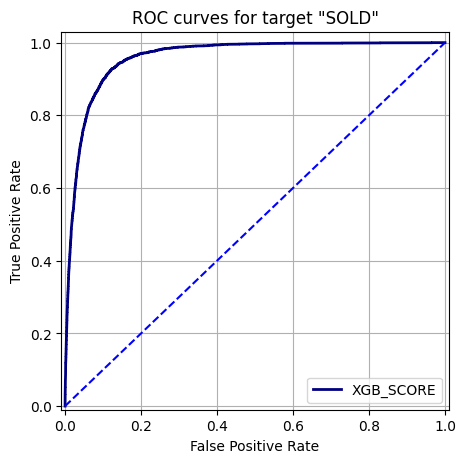

In [84]:
from mofr.basic_evaluators.ROCCurve import ROCCurveEvaluator
df['one']=1

rce=ROCCurveEvaluator()
rce.d(df[valid_mask]).t([(col_target,'one')]).s(['XGB_SCORE'])
rce.get_graph()

del df['one']

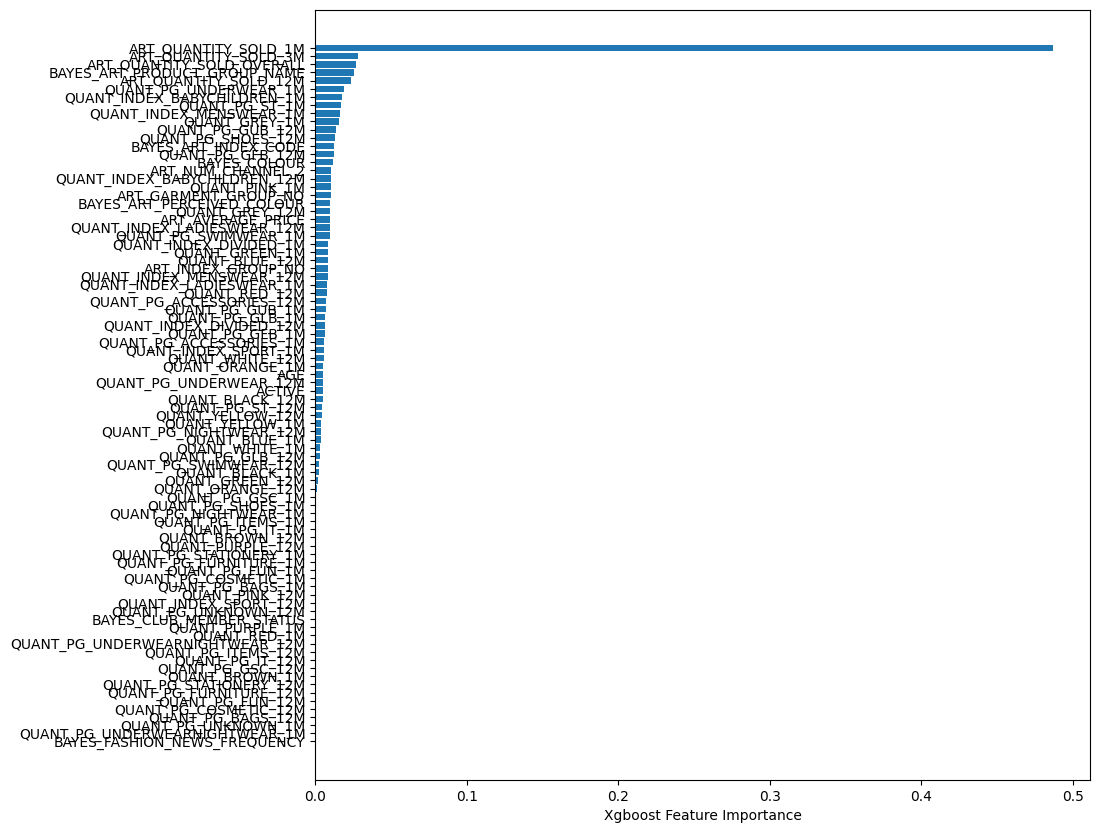

In [85]:
sorted_idx = xgb_model.feature_importances_.argsort()
order_ = []
for i in sorted_idx:
  order_.append(col_preds[i])
plt.figure(figsize=(10, 10))
fig = plt.barh(order_, xgb_model.feature_importances_[sorted_idx])
plt.xlabel("Xgboost Feature Importance")
plt.show()

In [86]:
# results=[]
# for col in col_preds:
#     results.append((col, np.abs(mofr.metrics.gini(df[valid_mask][col_target], df[valid_mask][col]))))
  
# pd.DataFrame(results, columns=['Predictor', 'GINI']).sort_values(by='GINI', ascending=False)[0:30]

### Saving the model

In [87]:
import pickle
file_name = "hm_xgb_model.pkl"

# save
pickle.dump(xgb_model, open(file_name, "wb"))

# # load
# #xgb_model= pickle.load(open(file_name, "rb"))

In [88]:
import pickle
file_name = "hm_encoder.pkl"

# save
pickle.dump(encoder, open(file_name, "wb"))

# # load
# #encoder = pickle.load(open(file_name, "rb"))

# Additional checks

In [89]:
df.head()

,SOLD,SNAP_DATE,CUSTOMER_ID,ARTICLE_ID,ACTIVE,CLUB_MEMBER_STATUS,FASHION_NEWS_FREQUENCY,AGE,QUANT_PG_ACCESSORIES_1M,QUANT_PG_BAGS_1M,...,CUSTART_DAYS_SINCE_FIRST_PURCHASE,CUSTART_DAYS_SINCE_LAST_PURCHASE,CUSTART_NUM_CHANNEL_2,BAYES_CLUB_MEMBER_STATUS,BAYES_FASHION_NEWS_FREQUENCY,BAYES_ART_PRODUCT_GROUP_NAME,BAYES_COLOUR,BAYES_ART_PERCEIVED_COLOUR,BAYES_ART_INDEX_CODE,XGB_SCORE
4300411,0,2020-09-01,ba0d65520a2a7a6036f2a492dadf8d2b432bde29feb3c8...,772946002,0.0,ACTIVE,NONE,27.0,0.0,0.0,...,NaN,NaN,NaN,0.106231,0.110317,0.129019,0.123890,0.108575,0.156111,0.002370
5074789,1,2020-09-01,e90f4121a9efb36aa10f5607245ea4074cb0adac24da05...,852584006,0.0,ACTIVE,NONE,55.0,0.0,0.0,...,NaN,NaN,NaN,0.106231,0.110317,0.119507,0.161796,0.121389,0.163614,0.704462
6125080,0,2020-09-15,4fe3a44974dda837a3a338f9cf461172c8d2b6ac39d741...,775345001,0.0,ACTIVE,NONE,21.0,0.0,0.0,...,NaN,NaN,NaN,0.106231,0.110317,0.051002,0.161796,0.121389,0.082696,0.001600
5348374,0,2020-09-01,61d183dcae6e34fe8f5c2ccebd6b5b7f8b28ae48521c56...,620973001,0.0,ACTIVE,NONE,18.0,1.0,0.0,...,NaN,NaN,NaN,0.106231,0.110317,0.129019,0.161796,0.121389,0.166048,0.002191
154591,0,2020-09-15,2dbdc6efde46ff345bed0a27be932f03c65eced9040128...,734916001,0.0,ACTIVE,NONE,30.0,0.0,0.0,...,NaN,NaN,NaN,0.106231,0.110317,0.129019,0.111597,0.121389,0.015909,0.038737


## Categorical encoding check

## SHAP values

In [90]:
import shap  # package used to calculate Shap values

In [91]:
row_to_show = 1
data_for_prediction = df[train_mask][col_preds].iloc[row_to_show]  # use 1 row of data here. Could use multiple rows if desired
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)

# Create object that can calculate shap values
explainer = shap.TreeExplainer(xgb_model)

# Calculate Shap values
shap_values = explainer.shap_values(data_for_prediction_array)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, data_for_prediction)

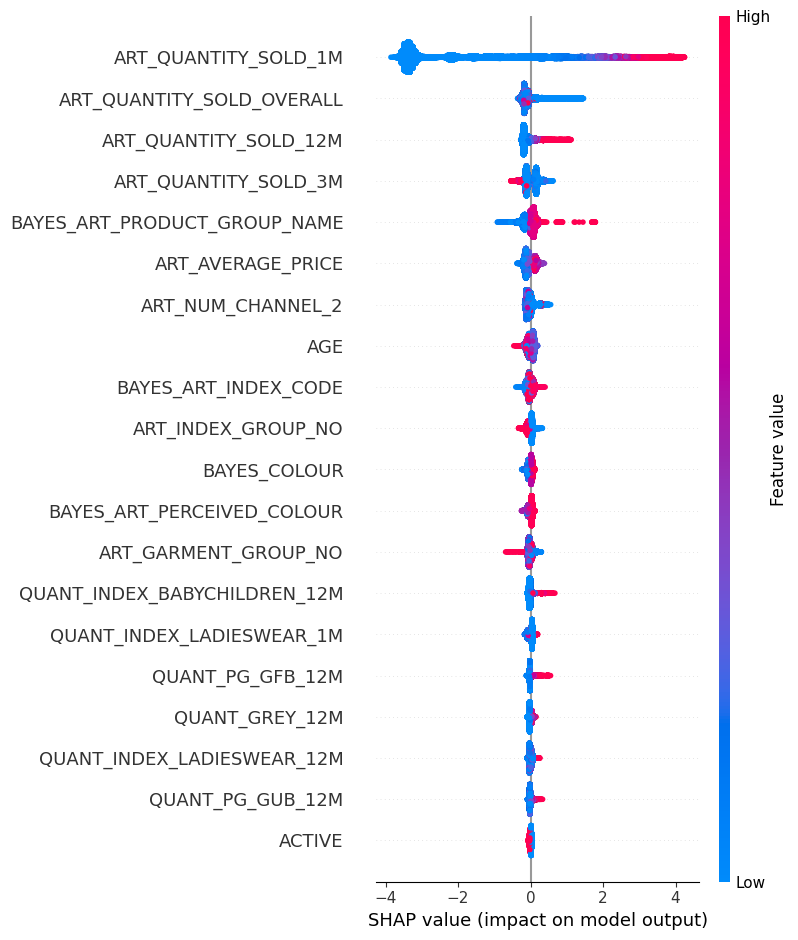

In [92]:
shap_values = explainer.shap_values(df[train_mask][col_preds])
shap.summary_plot(shap_values, df[train_mask][col_preds])

In [ ]:
shap.dependence_plot('ART_QUANTITY_SOLD_1M', shap_values, train[col_preds], interaction_index="Male_flag")

# Future predictions part

Simple article preselection approach was chosen-> top 1000 articles by average XGB_SCORE 

In [ ]:
# del df

In [ ]:
# import pickle
# file_name1= "hm_xgb_model.pkl"
# file_name2= "hm_encoder.pkl"

# # load
# xgb_model= pickle.load(open(file_name1, "rb"))
# encoder= pickle.load(open(file_name2, "rb"))

In [ ]:
import pandas as pd

In [ ]:
articles=pd.read_csv('/kaggle/input/hm-model-build-base/articles_predictions.csv').fillna(999)
customers=pd.read_csv('/kaggle/input/hm-model-build-base/customers_prediction.csv').fillna(0)

In [ ]:
del customers['Unnamed: 0']

In [ ]:
customers['CUSTOMER_ID10']=customers['CUSTOMER_ID'].apply(lambda x: x[0:10])

In [ ]:
articles['ARTICLE_ID6']=articles['ARTICLE_ID'].apply(lambda x: int(str(x)[0:6]))

## Scoring customers in batches to produce submission file
For each of the 1000 suggested items and for each customer, then ordering and picking top 12

In [ ]:
submission=pd.DataFrame()

In [ ]:
def process_chunk(chunk):
    chunk=chunk.rename(columns={'CUSTOMER_ID':'CUSTOMER_ID10'}).drop_duplicates()
    chunk.drop_duplicates(subset=['CUSTOMER_ID10', 'ARTICLE_ID'], inplace=True)
    chunk=chunk.merge(articles, how='left', on='ARTICLE_ID')
    chunk=chunk.merge(customers, how='left', left_on='CUSTOMER_ID10', right_on='CUSTOMER_ID10')
    chunk = pd.concat([chunk, encoder.transform(chunk[cat_preds]).add_prefix("BAYES_")], axis=1)
    
    chunk['XGB_SCORE']=xgb_model.predict_proba(chunk[xgb_model.feature_names_in_])[:, 1]
    chunk['ARTICLE_ID']=chunk['ARTICLE_ID'].apply(str).apply(lambda x: x.zfill(10))
    a=chunk[['CUSTOMER_ID', 'ARTICLE_ID', 'XGB_SCORE']].groupby('CUSTOMER_ID').apply(lambda x : x.sort_values(by = 'XGB_SCORE', ascending = False).head(12).reset_index(drop = True)).reset_index(drop = True)
    b=pd.DataFrame(a.groupby('CUSTOMER_ID')['ARTICLE_ID'].apply(list).apply(' '.join)).reset_index(drop=False).rename(columns={'ARTICLE_ID':'PREDICTION'})
    return b

In [ ]:
# n=0
# chunksize = 10 ** 6
# with pd.read_csv('/kaggle/input/suggested-items/model_suggested_items.csv', chunksize=chunksize) as reader:
#     for chunk in reader:
#         print(f'{n}: {round(n/3.94,2)} % done')
#         submission=pd.concat([submission,process_chunk(chunk)])
#         n+=1

In [ ]:
# submission.drop_duplicates(subset='CUSTOMER_ID',keep='first', inplace=True, ignore_index=False)

In [ ]:
# submission.to_csv('submission.csv', index=False)